In [1]:
import prettyNEAT as pn
import domain
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import math
from collections import namedtuple
from torch import nn
import torch
import torchvision
from torchvision import transforms
import pandas as pd
from ribs.visualize import grid_archive_heatmap
import sys
import os

In [2]:
x=np.linspace(-3.9375,3.9375,32)
x= x.repeat(32)
x=x.reshape((32,32))
x=np.stack((x,x.transpose()),axis=2)
r=np.sqrt(np.square(x).sum(axis=2))
x=np.append(x,np.expand_dims(r,2),axis=2)

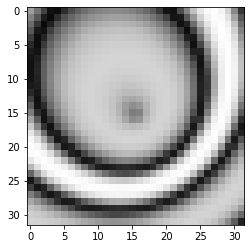

In [3]:
na=[[1,0,0,1,0,0,0,0],
   [1,1,0,1,0,0,0,0],
   [1,0,1,1,0,0,0,0],
   [1,0,0,1,0,0,0,0],
   [0,0,0,0,0,1,0,0],
   [0,0,0,0,1,0,1,0],
   [0,0,0,1,1,1,1,1],
   [0,0,0,1,0,0,0,1]]
im = PIL.Image.open("simple.png")
im1=im.convert("L").resize((32,32))
goal=np.array(im1)/255
goal=np.expand_dims(goal,2)
im.close()
plt.imshow(goal, cmap='Greys_r',vmin=0, vmax=1)

In [4]:
def getMyFitness(game, wVec, aVec, nRep=False,):
    if nRep is False:
        nRep = game.nReps
    wVec[np.isnan(wVec)] = 0
    reward = np.empty(nRep)
    for iRep in range(nRep):
        reward[iRep] = myTestInd(game, wVec, aVec)
    fitness = np.mean(reward)
    return fitness

def myTestInd(game, wVec, aVec):
    myPic = np.empty((32,32,1))      
    for i in range(game.maxEpisodeLength): 
        myPic[i%32][int(i/32)] = pn.act(wVec, aVec, game.nInput, game.nOutput, x[i%32][int(i/32)])
    return (np.square(goal-myPic).sum()-(32*32))/((-32*32))*100

In [5]:
Game = namedtuple('Game', ['env_name', 'time_factor', 'actionSelect',
  'input_size', 'output_size', 'layers', 'i_act', 'h_act',
  'o_act', 'weightCap','noise_bias','output_noise','max_episode_length','in_out_labels'])

game= Game(env_name='cppn',
  actionSelect='all', # all, soft, hard
  input_size=3,
  output_size=1,
  time_factor=0,
  layers=[64, 64],
  i_act=np.full(3,1),
  h_act=[1,3,4,10],
  o_act=np.full(1,6),
  weightCap = 25,
  noise_bias=0.0,
  max_episode_length = 32*32,
  output_noise=[False],
  in_out_labels = ['Pixel Intensity'])

In [8]:
hyp = domain.loadHyp(pFileName='C:\\Users\\mmkir\\Documents\\485\\indeptant study\\prettyNEAT\\config\\default_neat.json')
hyp['alg_nReps']=1
task = domain.GymTask(game, paramOnly=True, nReps=hyp['alg_nReps'])
hyp['ann_nInput']   = task.nInput
hyp['ann_nOutput']  = task.nOutput
hyp['ann_initAct']  = task.activations
hyp['ann_absWCap']  = task.absWCap
hyp['ann_mutSigma'] = task.absWCap * 0.2
hyp['ann_layers']   = task.layers
hyp['ann_actRange'] = task.actRange
hyp['bc_range']=[[0,64],[0,31]]
hyp['map_size']=[16,16]
hyp['maxGen']=10000
hyp['pop_size']=512
hyp['prob_mutAct']= 0.05
hyp['prob_addNode']= 0.06
hyp['prob_addConn']= 0.08
hyp["select_tournSize"]= 128
neat = pn.Neat(hyp)

In [8]:
neat = pn.Neat(hyp)
for gen in range(hyp['maxGen']):
    pop = neat.ask()
# Get newly evolved individuals from NEAT
    reward = np.empty(len(pop), dtype=np.float64)
    for i in range(len(pop)):
        task = domain.GymTask(game, paramOnly=True, nReps=hyp['alg_nReps'])
        wVec   = pop[i].wMat.flatten()
        aVec   = pop[i].aVec.flatten()
        reward[i] = getMyFitness(task, wVec, aVec) # process it
    neat.tell(reward)
    neat.gen += 1
    if gen % 25 == 0:
        my_max=(np.mean(reward))
        print(f'gen:{gen}, avg fitness:{my_max:.3f}')
        if my_max > 99.5:
            print("sucess")
            break

gen:0, avg fitness:69.155
gen:25, avg fitness:73.596
gen:50, avg fitness:72.315
gen:75, avg fitness:74.312
gen:100, avg fitness:74.038
gen:125, avg fitness:72.751
gen:150, avg fitness:73.437
gen:175, avg fitness:73.791
gen:200, avg fitness:71.809
gen:225, avg fitness:72.776
gen:250, avg fitness:71.907
gen:275, avg fitness:72.513
gen:300, avg fitness:72.755
gen:325, avg fitness:72.521
gen:350, avg fitness:73.443
gen:375, avg fitness:72.908
gen:400, avg fitness:71.441
gen:425, avg fitness:73.492
gen:450, avg fitness:72.805
gen:475, avg fitness:74.558
gen:500, avg fitness:73.306
gen:525, avg fitness:72.844
gen:550, avg fitness:72.393
gen:575, avg fitness:72.246
gen:600, avg fitness:73.989
gen:625, avg fitness:73.840
gen:650, avg fitness:73.604
gen:675, avg fitness:73.542
gen:700, avg fitness:73.779
gen:725, avg fitness:72.178
gen:750, avg fitness:73.985
gen:775, avg fitness:73.904
gen:800, avg fitness:74.410
gen:825, avg fitness:73.967
gen:850, avg fitness:72.811
gen:875, avg fitness:72.7

gen:7125, avg fitness:73.736
gen:7150, avg fitness:72.643
gen:7175, avg fitness:72.768
gen:7200, avg fitness:73.375
gen:7225, avg fitness:72.861
gen:7250, avg fitness:72.464
gen:7275, avg fitness:72.789
gen:7300, avg fitness:73.519
gen:7325, avg fitness:73.236
gen:7350, avg fitness:73.769
gen:7375, avg fitness:73.580
gen:7400, avg fitness:73.441
gen:7425, avg fitness:73.594
gen:7450, avg fitness:72.537
gen:7475, avg fitness:71.554
gen:7500, avg fitness:73.428
gen:7525, avg fitness:73.679
gen:7550, avg fitness:73.478
gen:7575, avg fitness:73.566
gen:7600, avg fitness:74.283
gen:7625, avg fitness:73.331
gen:7650, avg fitness:73.600
gen:7675, avg fitness:73.322
gen:7700, avg fitness:73.262
gen:7725, avg fitness:73.171
gen:7750, avg fitness:74.276
gen:7775, avg fitness:72.929
gen:7800, avg fitness:73.804
gen:7825, avg fitness:72.570
gen:7850, avg fitness:73.630
gen:7875, avg fitness:73.072
gen:7900, avg fitness:74.095
gen:7925, avg fitness:73.184
gen:7950, avg fitness:73.280
gen:7975, avg 

In [9]:
class NeatME(pn.Neat):
    def __init__(self,hyp):
        super().__init__(hyp)
        self.map_elites={}
    def ask(self):
    
        if len(self.pop) == 0:
            self.initPop()      # Initialize population
        else:
            self.probMoo() # Rank population according to objectivess
            self.fill_elites()
            self.gen_with_elites()# Create child population
        return self.pop
    
    def tell(self,reward,bc0,bc1):
        super().tell(reward)
        for i in range(np.shape(reward)[0]):
            #self.pop[i].bc0=bc0[i]
            self.pop[i].bc1=bc1[i]

   
    def fill_elites(self, to_fill=None):
        if to_fill is None:
            to_fill = self.pop
        map_size = self.p["map_size"]
        bc_range = self.p['bc_range']
        for my_ind in to_fill:
            adjusted_bc0=math.ceil((my_ind.bc0-bc_range[0][0])/(bc_range[0][1]-bc_range[0][0])*map_size[0])-1
            adjusted_bc1=math.ceil((my_ind.bc1-bc_range[1][0])/(bc_range[1][1]-bc_range[1][0])*map_size[1])-1
            
            if adjusted_bc0>map_size[0]-1:
                adjusted_bc0 = map_size[0]-1
            elif adjusted_bc0<0:
                adjusted_bc0 =0
                
            if adjusted_bc1>map_size[1]-1:
                adjusted_bc1 = map_size[1]-1
            elif adjusted_bc1<0:
                adjusted_bc1 =0 
                
            key =adjusted_bc0*map_size[1] + adjusted_bc1
            if key in self.map_elites:
                if self.map_elites[key].fitness<my_ind.fitness:
                    self.map_elites[key]=my_ind
            else:
                self.map_elites[key]=my_ind
    
    def gen_with_elites(self):
        new_pop = []
        pop_size = neat.p['popSize']
        numberToCull = int(np.floor(self.p['select_cullRatio'] * len(neat.pop)))
        if numberToCull > 0:
            neat.pop[-numberToCull:] = []
        parentB=np.random.randint(len(neat.pop),size=(pop_size,neat.p['select_tournSize']))
        parentB = np.min(parentB,1)
        a_list=[*self.map_elites.values()]
        for i in range(pop_size):
            parentA=random.choice(a_list)
            if np.random.rand() > self.p['prob_crossover']:
                child, self.innov = parentA.createChild(neat.p,neat.innov,neat.gen)
            else:
                child, self.innov = parentA.createChild(neat.p, neat.innov, neat.gen, mate=neat.pop[parentB[i]])
            child.express()
            new_pop.append(child)
        self.pop=new_pop

In [10]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, stride=2, 
            padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, 
            padding=1, output_padding=0)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [11]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
encoder.float()
decoder.float()
def train_epoch_den(encoder, decoder, device, archive, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in archive: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = torch.from_numpy(image_batch.pic).squeeze().expand(1,1,-1,-1).float()
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.max(train_loss)

def test_encode(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        losses = np.empty(len(dataloader))
        for i, image_batch in enumerate(dataloader):
            # Move tensor to the proper device
            image_batch = torch.from_numpy(image_batch.pic).squeeze().expand(1,1,-1,-1).float()
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            losses[i]=loss_fn(decoded_data.cpu(), image_batch.cpu())
    return losses


Selected device: cpu


In [12]:
def getMyFitnessBc(game, wVec, aVec, ind):
    wVec[np.isnan(wVec)] = 0    
    fitness, bc0 = myTestInd(game, wVec, aVec, ind)
    ind.bc0 = bc0
    return fitness, bc0

def myTestInd(game, wVec, aVec, ind):
    myPic = np.empty((32,32,1))      
    for i in range(game.maxEpisodeLength): 
        myPic[i%32][int(i/32)] = pn.act(wVec, aVec, game.nInput, game.nOutput, x[i%32][int(i/32)])
    ind.pic = myPic
    return (np.square(goal-myPic).sum()-(32*32))/((-32*32))*100, aVec.size

In [13]:
def redo_bc1(inds):
    bc1s = test_encode(encoder, decoder, device, inds, loss_fn)
    for i, ind in enumerate(inds):
        ind.bc1=bc1s[i]
        
def save_elites(my_map, folder, size):
    os.mkdir(folder)
    elite_pic = np.empty(size)
    pdic = {'bc0':[],'bc1':[],'fitness':[]}
    for i in range(size[0]):
        for j in range(size[1]):
            key = i*size[1]+j
            if key in my_map:
                elite_pic[i][j]=my_map[key].fitness
                pdic['bc0'].append(i)
                pdic['bc1'].append(j)
                pdic['fitness'].append(my_map[key].fitness)
            else:
                elite_pic[i][j]=np.nan
    #grid_archive_heatmap(elite_pic,vmin=0, vmax=100)
    #plt.tight_layout()
    #plt.savefig(f'{my_map}/mapOelites.png')
    ar = pd.DataFrame(data=pdic)
    pics=[]
    for i in range(6):
        for j in range(6):
            partion=ar.loc[
                (ar["bc0"]>(j*size[0]/6))&
                (ar["bc0"]<((j+1)*size[0]/6))&
                (ar["bc1"]>(size[1]-(i+1)*size[1]/6))&
                (ar["bc1"]<(size[1]-(i)*size[1]/6))]
            if partion.empty:
                pics.append(na)
            else:
                max_obj=partion[(partion["fitness"].max()==partion["fitness"])]
                a = partion['bc0'].to_numpy()[0]
                b = partion['bc1'].to_numpy()[0]
                max_loc=a*size[1]+b
                pics.append(my_map[max_loc].pic)

    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Best Images")
    for i,p in enumerate(pics):
        plt.subplot(6,6,i+1)
        plt.imshow(p, cmap='Greys_r',vmin=0,vmax=1)
    plt.savefig(str(f'{folder}/results.png'))


In [ ]:
folder= "simple2"
neat = NeatME(hyp)
mymapsize=neat.p["map_size"][0]*neat.p["map_size"][1]
for gen in range(hyp['maxGen']):
    pop = neat.ask()
# Get newly evolved individuals from NEAT
    reward = np.empty(len(pop), dtype=np.float64)
    bc0 = np.empty(len(pop), dtype=np.float64)
    archive = []
    q = 0
    for i in range(len(pop)):
        task = domain.GymTask(game, paramOnly=True, nReps=hyp['alg_nReps'])
        wVec   = pop[i].wMat.flatten()
        aVec   = pop[i].aVec.flatten()
        reward[i], bc0[i] = getMyFitnessBc(task, wVec, aVec, pop[i]) # process it
    a_len = len(archive)
    #make full archive
    if len(archive)>5000:
        for po in pop:
            archive[q]=po
            q = (q+1)%a_len
    else:
        for po in pop:
            archive.append(po)
    if gen % 2000 == 0:
        max_loss = 0
        print('training autoencoder')
        for i in range(250):
            max_loss = train_epoch_den(encoder, decoder, device, archive, loss_fn, optim)
        print('finished autoencoder')
        neat.p['bc_range'][1][1]=max_loss
        elites=[*neat.map_elites.values()]
        neat.map_elites={}
        redo_bc1(archive)
        redo_bc1(elites)
        neat.tell(reward, bc0, test_encode(encoder, decoder, device, neat.pop, loss_fn))
        neat.fill_elites(elites)
        neat.fill_elites(archive)
    else:
        neat.tell(reward, bc0, test_encode(encoder, decoder, device, neat.pop, loss_fn))
    neat.gen += 1
    if gen % 25 == 0:
        my_max=(np.max(reward))
        cov = len(neat.map_elites)/mymapsize*100
        print(f'gen:{gen}, max fitness:{my_max:.3f}, archive coverage:{cov}%')
        if my_max > 99.5:
            print(my_max)
            break
save_elites(neat.map_elites, folder, neat.p['map_size'])

training autoencoder
finished autoencoder
gen:0, max fitness:76.516, archive coverage:3.125%
gen:25, max fitness:75.717, archive coverage:6.25%
gen:50, max fitness:77.511, archive coverage:6.25%
gen:75, max fitness:76.457, archive coverage:6.25%
gen:100, max fitness:76.258, archive coverage:6.25%
gen:125, max fitness:76.408, archive coverage:6.25%
gen:150, max fitness:79.145, archive coverage:6.25%
gen:175, max fitness:77.329, archive coverage:6.25%
gen:200, max fitness:77.005, archive coverage:6.25%
gen:225, max fitness:81.459, archive coverage:6.25%
gen:250, max fitness:77.391, archive coverage:6.25%
gen:275, max fitness:87.021, archive coverage:6.25%
gen:300, max fitness:78.317, archive coverage:6.25%
gen:325, max fitness:80.423, archive coverage:6.25%
gen:350, max fitness:76.209, archive coverage:6.25%
gen:375, max fitness:80.385, archive coverage:6.25%
gen:400, max fitness:82.505, archive coverage:6.25%
gen:425, max fitness:78.845, archive coverage:6.25%
gen:450, max fitness:77.03

gen:3825, max fitness:78.186, archive coverage:18.75%
gen:3850, max fitness:85.418, archive coverage:18.75%
gen:3875, max fitness:82.413, archive coverage:18.75%
gen:3900, max fitness:86.624, archive coverage:18.75%
gen:3925, max fitness:88.301, archive coverage:18.75%
gen:3950, max fitness:79.577, archive coverage:18.75%
gen:3975, max fitness:88.187, archive coverage:18.75%
training autoencoder
finished autoencoder
gen:4000, max fitness:92.539, archive coverage:10.9375%
gen:4025, max fitness:86.306, archive coverage:18.359375%
gen:4050, max fitness:76.769, archive coverage:18.75%
gen:4075, max fitness:89.553, archive coverage:18.75%
gen:4100, max fitness:79.362, archive coverage:18.75%
gen:4125, max fitness:86.333, archive coverage:18.75%
gen:4150, max fitness:88.990, archive coverage:18.75%
gen:4175, max fitness:83.054, archive coverage:18.75%
gen:4200, max fitness:83.381, archive coverage:18.75%
gen:4225, max fitness:83.021, archive coverage:18.75%
gen:4250, max fitness:91.445, arch

gen:7500, max fitness:82.153, archive coverage:18.359375%
gen:7525, max fitness:79.372, archive coverage:18.359375%
gen:7550, max fitness:91.029, archive coverage:18.359375%
gen:7575, max fitness:89.842, archive coverage:18.359375%
gen:7600, max fitness:82.103, archive coverage:18.359375%
gen:7625, max fitness:89.851, archive coverage:18.359375%
gen:7650, max fitness:82.746, archive coverage:18.359375%
gen:7675, max fitness:86.451, archive coverage:18.359375%
gen:7700, max fitness:83.396, archive coverage:18.359375%
gen:7725, max fitness:87.636, archive coverage:18.359375%
gen:7750, max fitness:82.069, archive coverage:18.359375%
gen:7775, max fitness:81.078, archive coverage:18.359375%
gen:7800, max fitness:84.118, archive coverage:18.359375%
